In [3]:
!pip install diffprivlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
import time
import psutil

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [4]:
start_time = time.time()
url = 'Real_estate_valuation.csv'
column_names = ['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude',
                'X6 longitude', 'Y house price of unit area']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)


In [5]:
dataset = raw_dataset.copy()

In [6]:
dataset = dataset.dropna()
dataset = dataset.iloc[1:]
dataset.head()

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
1,32,84,87882,10,24,98298
2,19,5,306,5947,9,24
3,13,3,561,9845,5,24
4,13,3,561,9845,5,24
5,5,390,5684,5,24,97937


In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)


In [8]:
X_train = train_dataset.copy()
X_test = test_dataset.copy()

y_train = X_train.pop('Y house price of unit area')
y_test = X_test.pop('Y house price of unit area')


In [9]:
from sklearn.linear_model import LinearRegression as sk_LinearRegression

regr = Pipeline([
    ('scaler', Normalizer()), 
    ('clf', sk_LinearRegression()) 
])

regr.fit(X_train, y_train)

baseline = regr.score(X_test, y_test)
print("Non-private baseline R2 score: %.2f" % baseline)


Non-private baseline R2 score: 0.52


In [10]:
from diffprivlib.models import LinearRegression
dp_regr = Pipeline([
    ('scaler', Normalizer()), 
    ('clf', LinearRegression(epsilon=float('inf'))) 
])

dp_regr.fit(X_train, y_train)

baseline2 = dp_regr.score(X_test, y_test)
print("private baseline R2 score: %.2f" % baseline2)


private baseline R2 score: 0.52


/usr/local/lib/python3.6/dist-packages/diffprivlib/models/linear_regression.py:258: PrivacyLeakWarning: Bounds parameters haven't been specified, so falling back to determining bounds from the data.
This will result in additional privacy leakage. To ensure differential privacy with no additional privacy loss, specify `bounds_X` and `bounds_y`.
  PrivacyLeakWarning)


In [11]:
epsilons = np.logspace(-3, 2, 500)
accuracy = []
cpu_Overhead = []
mem_Overhead = []

for epsilon in epsilons:
    dp_regr.fit(X_train, y_train)

    cpu_Overhead.append(psutil.cpu_percent())
    psutil.virtual_memory()
    dict(psutil.virtual_memory()._asdict())
    mem_Overhead.append(psutil.virtual_memory().percent)   

    accuracy.append(dp_regr.score(X_test, y_test))

--- 19.308727502822876 seconds ---


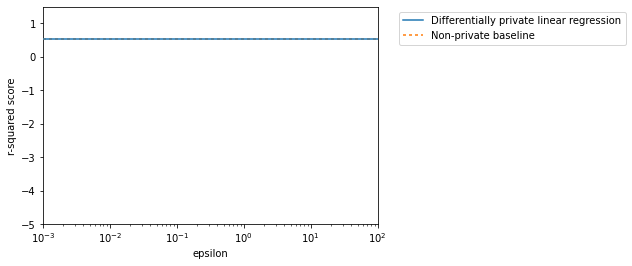

In [12]:
print("--- %s seconds ---" % (time.time() - start_time))
plt.semilogx(epsilons, accuracy, label="Differentially private linear regression", zorder=10)
plt.semilogx(epsilons, baseline * np.ones_like(epsilons), dashes=[2,2], label="Non-private baseline", zorder=5)
plt.xlabel("epsilon")
plt.ylabel("r-squared score")
plt.ylim(-5, 1.5)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [13]:
print(sum((cpu_Overhead))/500)
print(sum((mem_Overhead))/500)

51.230599999999974
6.199999999999959


In [14]:
accuracy_final1 = []
for _ in " "*10: 
  dp_regr.set_params(clf__epsilon=1).fit(X_train, y_train) 
  accuracy_final1.append(dp_regr.score(X_test, y_test))


In [15]:
accuracy_final01 = []
for _ in " "*10: 
  dp_regr.set_params(clf__epsilon=1).fit(X_train, y_train) 
  accuracy_final01.append(dp_regr.score(X_test, y_test))


In [16]:
accuracy_final001 = []
for _ in " "*10: 
  dp_regr.set_params(clf__epsilon=1).fit(X_train, y_train) 
  accuracy_final001.append(dp_regr.score(X_test, y_test))


In [17]:
accuracy_final = []
#accuracy_final1.remove(max(accuracy_final1))
#accuracy_final1.remove(min(accuracy_final1))

#accuracy_final01.remove(max(accuracy_final01))
#accuracy_final01.remove(min(accuracy_final01))

#accuracy_final001.remove(max(accuracy_final001))
#accuracy_final001.remove(min(accuracy_final001))

accuracy_final.append(sum(accuracy_final1)/10)
accuracy_final.append(sum(accuracy_final01)/10)
accuracy_final.append(sum(accuracy_final001)/10)

In [18]:
accuracy_final

[-729186679.6347493, -2857009.942579937, -48071979.20673801]

In [19]:
accuracy_NP = []
for _ in " "*10: 
  regr.fit(X_train, y_train) 
  accuracy_NP.append(regr.score(X_test, y_test))

In [20]:
print(sum(accuracy_NP)/10)

0.5212539482696643
